# Explicación

El objetivo es extraer información de las noticias diarias de la web del Diario de El Comercio para poder analizar el comportamiento de ciertas pátrones de las publicaciones. Por ejemplo:
 - Momento del día que hay mayor cantidad de publicaciones
 - Quién es el autor que más noticias publica
 - Que tópico es el más publicado alrededor de los días
 - Palabras más utilizadas en los títulos de las publicaciones
 

# Código

In [2]:
# Import the libraries of BeautifulSoup and request
# Author: Daniel Eduardo Olivera Calderon
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from datetime import date, timedelta

In [3]:
def iteration_news(param_list_news, final_list_news):
    # iterate the list of beautifulsoup of information news
    for new_html in param_list_news:
        date_publish =  new_html.find_all('span', class_ = 'story-item__date-time')[0]
        date_publish = date_publish.get_text()

        time_publish = new_html.find_all('span', class_ = 'story-item__date-time')[1]
        time_publish = time_publish.get_text()

        section = new_html.find('a', class_='story-item__section text-sm text-black md:mb-15')
        section = section.get_text()

        title = new_html.find('a', class_='story-item__title block overflow-hidden primary-font line-h-xs mt-10')
        title = title.get_text()

        description = new_html.find('p', class_='story-item__subtitle overflow-hidden hidden mt-10 mb-10 text-md text-gray-200 line-h-xs')
        description = description.get_text()

        author = new_html.find('a', class_='story-item__author block uppercase mt-10 font-thin text-xs text-gray-200')
        author = author.get_text()

        link_new = new_html.find('a', class_='story-item__title block overflow-hidden primary-font line-h-xs mt-10')['href']
        link_new = link_new
        
        final_list_news.append([date_publish, time_publish, section, title, description, author, link_new])
    return final_list_news

In [4]:
# iterate of beautifulsoup in seven days
def iteration_days(str_url):
    list_information_news = []
    url_initial = str_url
    lista = []
    for d in range(7):
        today = date.today() - timedelta(days=d+1)
        today = today.strftime('%Y-%m-%d')
        url_initial = str_url + today
    
        page = requests.get(url_initial)
        soup = BeautifulSoup(page.content, 'html.parser')
    
        body_html = soup.body
        div_html = body_html.find('div', class_="paginated-list--infinite")
        list_html_news = div_html.find_all('div', class_='story-item w-full pr-20 pl-20 pb-20 mb-20 border-b-1 border-solid border-gray md:pl-0 md:pr-0 lg:p-0')
        list_information_news = iteration_news(list_html_news, list_information_news)
        
    dataframe_news = pd.DataFrame(list_information_news, columns = ['Fecha', 'Hora', 'Seccion', 'Titulo', 'Descripcion', 'Autor', 'link'])
    
    return dataframe_news

In [5]:
# Indicate the url of the news
url = "https://elcomercio.pe/archivo/todas/"
df_news = iteration_days(url)

In [6]:
df_news.head()

,Fecha,Hora,Seccion,Titulo,Descripcion,Autor,link
0,25/05/2024,23:57,Fútbol peruano,Universitario - Los Chankas: merengues golearo...,Universitario golea a Los Chankas y consigue e...,Redacción EC,/deporte-total/futbol-peruano/link-universitar...
1,25/05/2024,23:53,Voz Universitaria,"Donde existe un desafío, existe una oportunidad",“La correcta implementación de esta nueva ley ...,Daniel García Calle,/opinion/voz-universitaria/donde-existe-un-des...
2,25/05/2024,23:53,Voz Universitaria,Desafíos en la inmunización infantil,“Es crucial que los padres prioricen el llevar...,Kiara Ramos,/opinion/voz-universitaria/desafios-en-la-inmu...
3,25/05/2024,23:53,Voz Universitaria,La integración de la IA en el derecho administ...,“La aplicación de la inteligencia artificial d...,Julio César Huamán,/opinion/voz-universitaria/la-integracion-de-l...
4,25/05/2024,23:46,Centroamérica,Honduras: Desaparece avioneta en la que viajab...,La aeronave de uso privado tenía previsto ater...,Redacción EC,/mundo/centroamerica/honduras-desaparece-avion...


In [7]:
# Rank 10 of authors that writes more news
df_rank_author = df_news.groupby('Autor').size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)
df_rank_author

,Autor,count
71,Redacción EC,470
4,Agencia EFE,70
2,Agencia AFP,23
5,Agencia Europa Press,6
23,Felipe Casapía Coello,5
9,BBC News Mundo,5
19,Eddie Fleischman,5
49,Karem Barboza Quiroz,4
20,Editorial El Comercio,4
78,Sonia del Águila,3


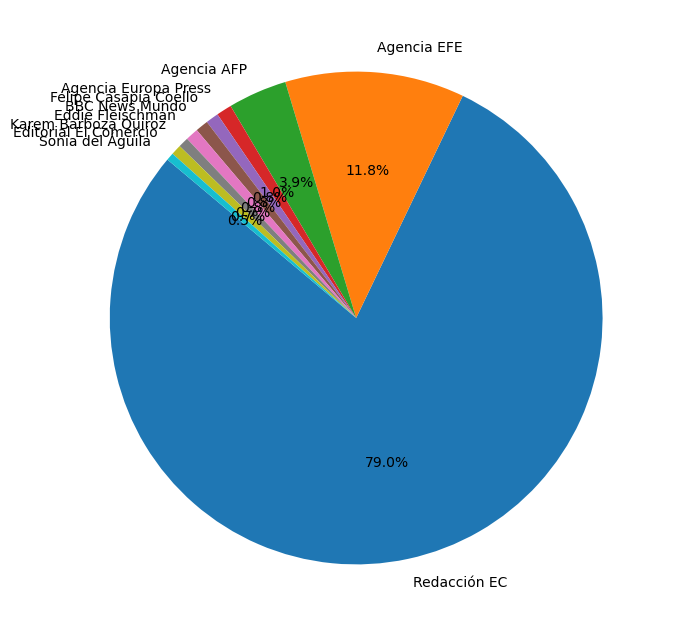

In [9]:
# A pie chart of the top 10 of the authors that writes more news
plt.figure(figsize=(8,8))
plt.pie(df_rank_author['count'], labels = df_rank_author['Autor'],autopct='%1.1f%%', startangle=140)
plt.show()

In [10]:
# Rank 10 of sections 
df_rank_seccion = df_news.groupby('Seccion').size().reset_index(name='count').sort_values(by='count', ascending = False).head(10)
df_rank_seccion

,Seccion,count
42,Fútbol peruano,56
79,Qué,47
52,Latinoamérica,30
70,Perú,29
4,Actualidad,27
87,Sucesos,23
39,Farándula,23
53,Lima,19
25,Deportes,18
66,Oriente Medio,18


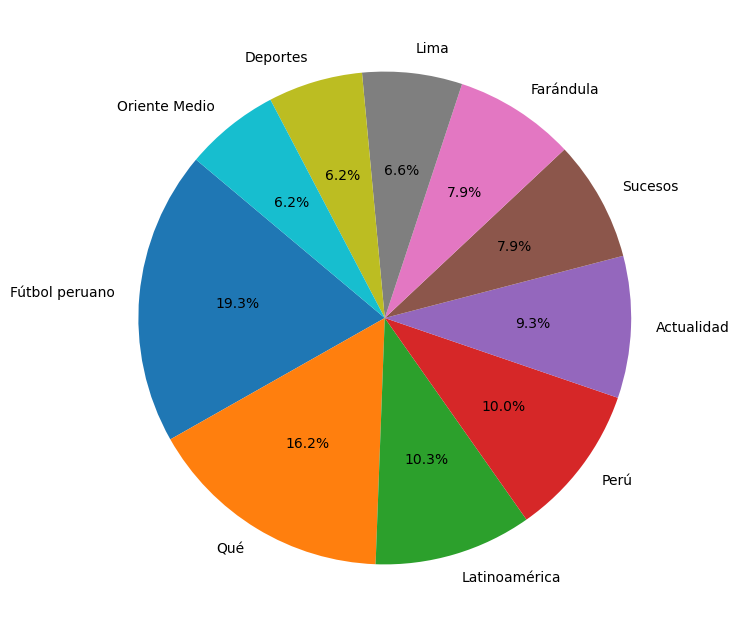

In [11]:
# A pie chart of the top 10 of sections that is more writes
plt.figure(figsize=(8,8))
plt.pie(df_rank_seccion['count'], labels = df_rank_seccion['Seccion'],autopct='%1.1f%%', startangle=140)
plt.show()

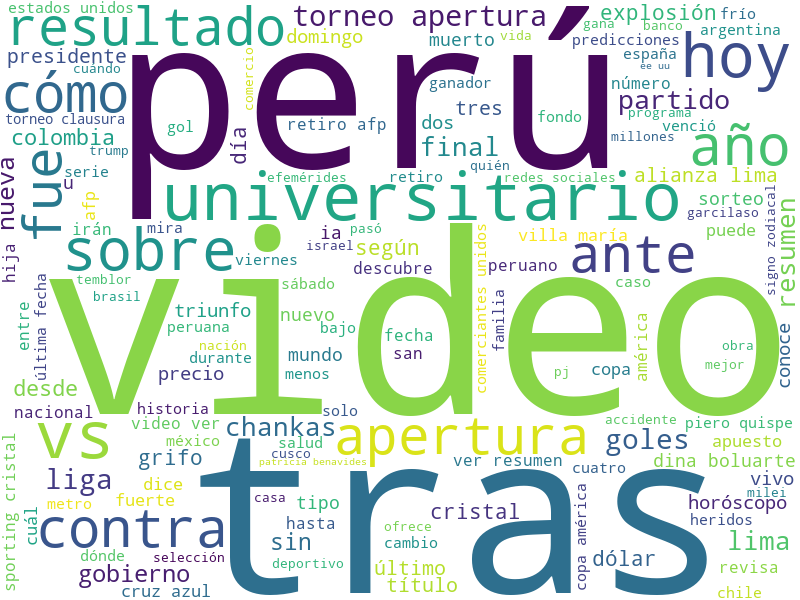

In [12]:
# Obtain a list of all words en all news
total_words = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es', 
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta', 
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han'
                             ,'mayo'])
for title in df_news['Titulo']:
    words = str(title).lower().split()
    for word in words:
        total_words = total_words + word + ' '

# Create the word cloud
word_cloud = WordCloud(width=800
                       , height = 600
                       , background_color = 'white'
                       , stopwords = stopwords
                       , min_font_size = 10
                      ).generate(total_words)
word_cloud.to_image()

In [13]:
# Create a new column that save the hour (HH)
df_news['hora_extraida'] = df_news['Hora'].str.extract(r'(\d+)', expand=False)
df_news['hora_extraida'] = df_news['hora_extraida'].astype(str)

In [14]:
# Calculate and group by hour the news 
df_news_rank_hora = df_news.groupby('hora_extraida').size().reset_index(name='Q_news').sort_values(by='Q_news', ascending=False)
df_news_rank_hora

,hora_extraida,Q_news
2,15,90
3,16,83
4,17,80
1,14,73
5,18,70
9,22,64
6,19,63
7,20,59
8,21,59
10,23,42


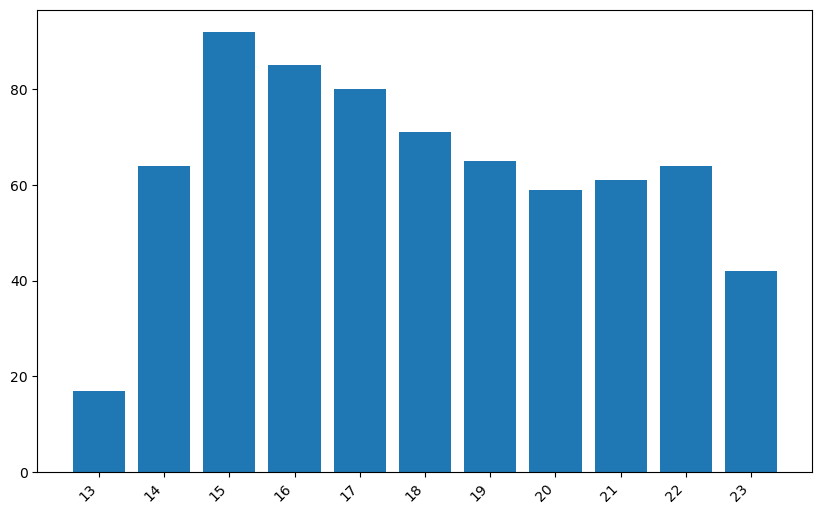

In [74]:
# Show in a graphic the behavior of the hours that the group news
df_news_rank_hora= df_news_rank_hora.sort_values(by='hora_extraida', ascending=True)
plt.figure(figsize=(10,6))
plt.bar(df_news_rank_hora['hora_extraida'], df_news_rank_hora['Q_news'])
plt.xticks(range(len(df_news_rank_hora['hora_extraida'])), df_news_rank_hora['hora_extraida'], rotation=45, ha='right')
plt.show()

# Análisis de los datos


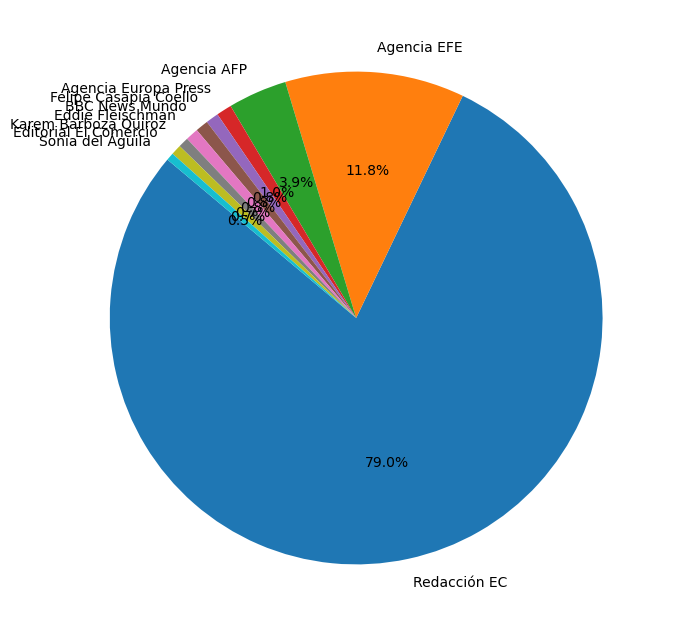

In [15]:
plt.figure(figsize=(8,8))
plt.pie(df_rank_author['count'], labels = df_rank_author['Autor'],autopct='%1.1f%%', startangle=140)
plt.show()

De acuerdo al pie chart el autor que publica mayor cantidad de mensajes es el usuario Redacción EC. Por lo que se puede indagar del nombre del usuario, debe ser una cuenta genérica utilizada para publicar, ya que las demás cuentas tienen nombre de cuentas de personas

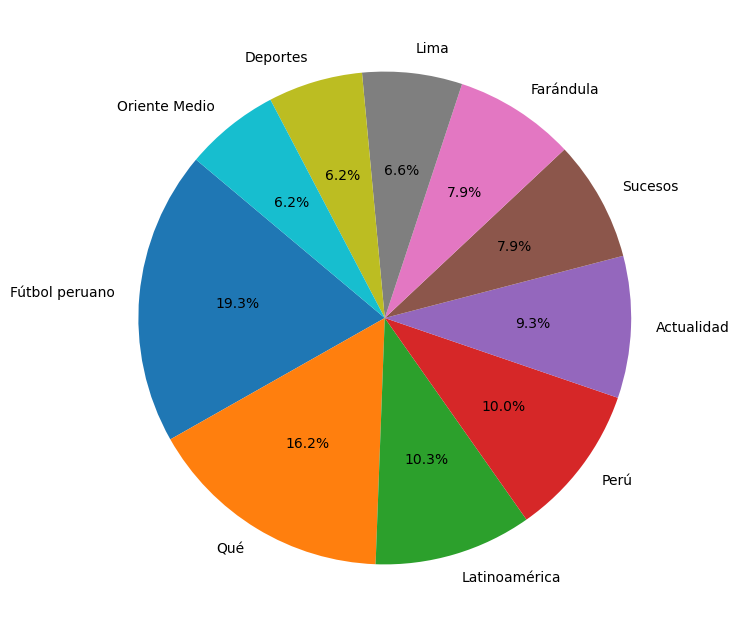

In [16]:
# A pie chart of the top 10 of sections that is more writes
plt.figure(figsize=(8,8))
plt.pie(df_rank_seccion['count'], labels = df_rank_seccion['Seccion'],autopct='%1.1f%%', startangle=140)
plt.show()

El piechart de rank sobre los temas de noticia con mayores publicaciones muestra que hasta la fecha de haber ejecutado el código: el futbol peruano lleva la cabecera en cantidad de publicaciones, seguidamente de la sección 'Qué' y de ahi viene Latinoamerica

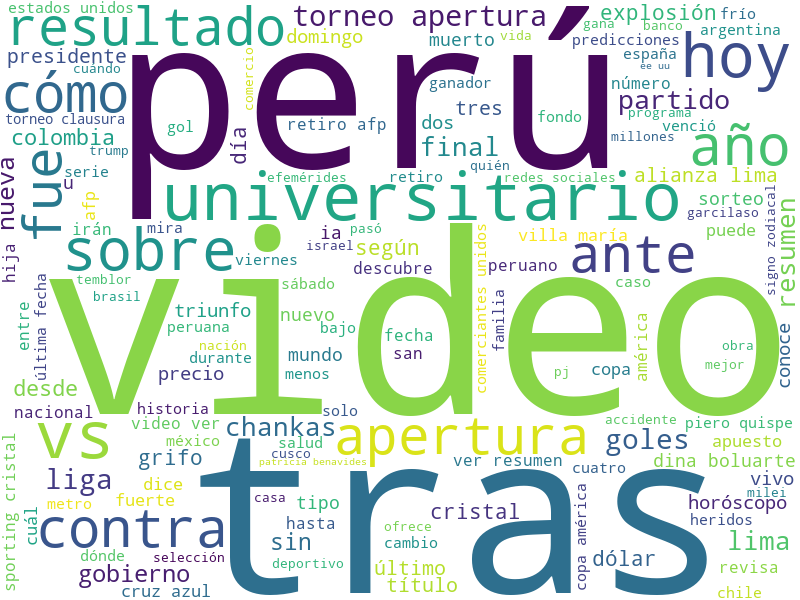

In [18]:
word_cloud.to_image()

Según la nube de palabras muestra que las palabras más utilizadas son Perú, Video, Tras, Apertura, Univerisatio, Torneo, Vs. 
Estas palabras se pueden entender que son las más utilizadas porque el fin de semana hubo un partido de futbol (deporte muy popular en el pais).

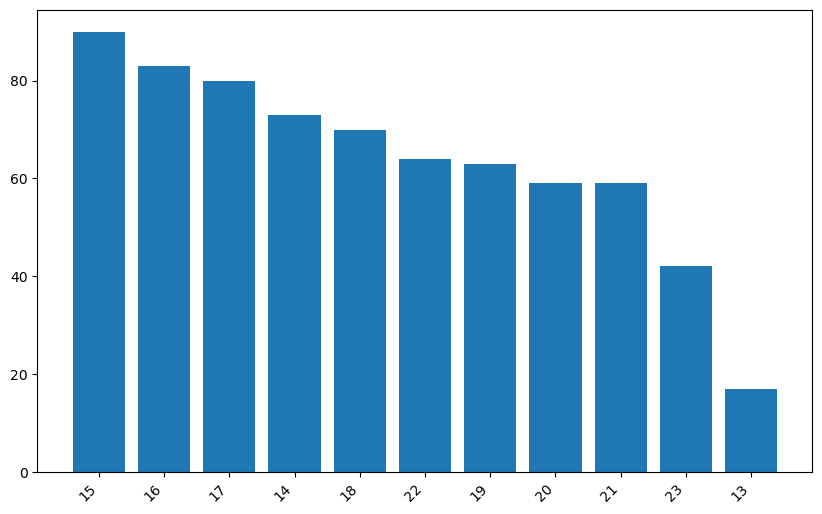

In [19]:
plt.figure(figsize=(10,6))
plt.bar(df_news_rank_hora['hora_extraida'], df_news_rank_hora['Q_news'])
plt.xticks(range(len(df_news_rank_hora['hora_extraida'])), df_news_rank_hora['hora_extraida'], rotation=45, ha='right')
plt.show()

Por último, por medio del gráfico de barras se puede analizar que la hora del día donde se publican mayor cantidad de noticias es a las 3pm, seguidamente de las 4pm y 5pm. La hora menos usada para publicaar es a la 1pm y en la madrugada no se publican noticias.